# Waveform fitting

In [1]:
# Setup ipython environment
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Setup the notebook's environment
import lalsimulation as lalsim
from matplotlib.pyplot import *
from numpy import *
from positive import *
from nrutils import scsearch, gwylm
from glob import glob
import xcp
from xcp import determine_data_fitting_region,calibration_catalog,metadata_dict,template_amp_phase

(positive)>> Applying custom matplotlib settings.
(init)>> Warm greetings from XCP.
(xcp.core)>> Catalog of calibration runs stored to "xcp.calibration_catalog"
(xcp.core)>> Metadata dictionary for calibration runs stored to "xcp.metadata_dict"
(xcp.core)>> Metadata dictionary for Ed's catalog paper stored to "xcp.catalog_paper_metadata"
(xcp.core)>> According to the global config, the XCP package is configured to model the [(3, 3)] coprecessing moment multipole moment(s)


In [2]:
# Let the user know where lalsimulation lives

#
lalsim_path = lalsim.__path__[0]
lalsuite_repo_path = lalsim_path.split('lib')[0]+'src/lalsuite/'
branch_name = bash('cd %s && git status'%lalsuite_repo_path).decode("utf-8").split('On branch ')[-1].split('\n')[0]

#
alert('We are getting our LALSimulation from:\n%s'%magenta(lalsim_path))
alert('We think that the related lalsuite source files are here:\n%s'%green(lalsuite_repo_path))
alert('Lastly, we are currently on this branch: %s'%bold(magenta(branch_name)))

#
if branch_name != 'pnrv1-ll':
    alert('We are not on the expected branch. This may cause unexpected behavior.',say=not True)

(notebook)>> We are getting our LALSimulation from:
/Users/book/opt/anaconda2/envs/hack-phenomx3/lib/python3.6/site-packages/lalsimulation
(notebook)>> We think that the related lalsuite source files are here:
/Users/book/opt/anaconda2/envs/hack-phenomx3/src/lalsuite/
(notebook)>> Lastly, we are currently on this branch: pnrv3-cp-bounded-dev
(notebook)>> We are not on the expected branch. This may cause unexpected behavior.


## This notebook is for prototyping and scratch code only. Please see scripts with same issue number.

(notebook)>> We are getting our LALSimulation from:
/Users/book/opt/anaconda2/envs/hack-phenomx3/lib/python3.6/site-packages/lalsimulation
(notebook)>> We think that the related lalsuite source files are here:
/Users/book/opt/anaconda2/envs/hack-phenomx3/src/lalsuite/
(notebook)>> Lastly, we are currently on this branch: pnrv3-cp-bounded-dev
(notebook)>> We are not on the expected branch. This may cause unexpected behavior.

# -~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~ #
(notebook)>> [(3, 3)]
# -~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~ #

(notebook)>> Plotting ...

# -~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~ #
(notebook)>> q8a08t30dPm9.35_r0.5_T_96_360
# -~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~ #

(notebook)>> [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.47272586e-05
 -5.45672939e-06  9.08495020e-06 -4.57127057e-05 -5.64389953e-06]
.(notebook)>> Fitting complete.
(notebook)>> Plotting complete.
(notebook)>> Saving complete.


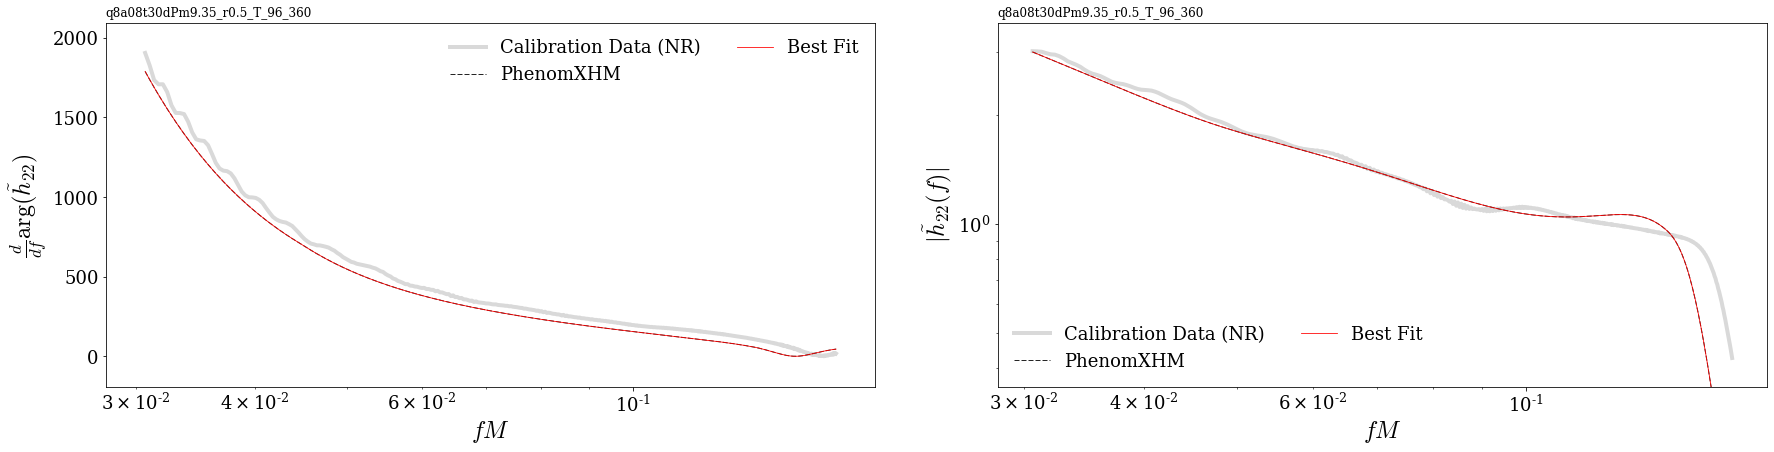

In [4]:
#!/usr/bin/env python3

# Setup the environment
import lalsimulation as lalsim
from matplotlib.pyplot import *
from numpy import *
from positive import *
from nrutils import scsearch, gwylm
from glob import glob
import xcp
from xcp import determine_data_fitting_region,calibration_catalog,metadata_dict,template_amp_phase, gc
from numpy.linalg import norm
from scipy.optimize import curve_fit,minimize,fmin

# Let the user know where lalsimulation lives

#
lalsim_path = lalsim.__path__[0]
lalsuite_repo_path = lalsim_path.split('lib')[0]+'src/lalsuite/'
branch_name = bash('cd %s && git status'%lalsuite_repo_path).decode("utf-8").split('On branch ')[-1].split('\n')[0]

#
alert('We are getting our LALSimulation from:\n%s'%magenta(lalsim_path))
alert('We think that the related lalsuite source files are here:\n%s'%green(lalsuite_repo_path))
alert('Lastly, we are currently on this branch: %s'%bold(magenta(branch_name)))

#
if branch_name != 'pnrv1-ll':
    alert('We are not on the expected branch. This may cause unexpected behavior.',say=not True)

alert(str(gc.lmlist),header=True)
# For all pairs of l and m in the global config file
for ll,mm in gc.lmlist:

    #
    datadir = '/Users/book/KOALA/PhenomXCP/data/version2/'
    files = glob( datadir+'*_l%im%i.txt'%(ll,mm) )
    files.sort()
    files = files[::-1]

    #
    file_map = []
    for j,sn_ in enumerate(metadata_dict['simname']):
        
        # Find index location of this metadata in the list of file paths
        k = [ k for k,val in enumerate(files) if sn_ in val ][0]

        # 
        file_map.append(k)
        

    # Sort file paths like matadata so that we can then sort both according to distance between physical parameters
    files = array(files)[file_map]
        
    reference_index = 0
    # theta,m1,m2,eta,delta,chi_eff,chi_p,chi1,chi2,a1,a2,chi1_x,chi1_y,chi1_z,chi2_x,chi2_y,chi2_z
    mask = [0,3,9] # theta, eta, a1 -- the parameters that will be used to calculate distance for sorting
    coordinates = metadata_dict['array_data'][:,mask]
    coordinates[:,0] = cos(coordinates[:,0]) # use cos theta 
    index_map, sorted_coordinates = distance_sort( coordinates, reference_index, center=not False )

    #
    files = list(files[index_map])
    
    #
    if ll==3:
        files = [ f for f in files if 'q1' not in f  ]
        
        
    reverse_index_map = argsort( index_map ).astype(int) # array([ int(c) for c in argsort( index_map ) ]),dtype=int

    # Get number of parameters to be tuned
    scarecrow = template_amp_phase(0.5, 0.5,zeros(3),zeros(3),ell=2)
    var_count = scarecrow.__code__.co_argcount - 1

    #
    fig,ax = subplots( 1, 2, figsize=3*array([ 2.5*2/(0.618), 2.0*1 ]) )
    ax = ax.flatten()

    #
    tight_layout(pad=1,w_pad=4,h_pad=4)

    #
    foo = {}

    #
    lmlist = [ (ll,mm) ]

    #
    p = 0
    popt_array  = zeros( (len(files),var_count) )
    fit_obj_list = []
    physical_param_array = zeros( (len(files), 17) )
    alert('Plotting ...')
    for j,f_ in enumerate(files):
    
        if 'q8a08t30' in f_:#'q8a08t30' in f_:

            #
            simname = f_.split('/')[-1].split('_l%im%i.'%(ll,mm))[0]

            # Find index location of metadata for simname 
            k = [ k for k,val in enumerate(metadata_dict['simname']) if val in simname ][0]

            # Load data for this case
            raw_data = loadtxt(f_).T
            calibration_data, dphi_lorentzian_min, f_min, f_max, f_lorentzian_min = determine_data_fitting_region( raw_data, simname=simname, lm=(ll,mm) )

            # Collect params for this case 
            metadata = metadata_dict['array_data'][k,:]

            #
            f,amp_fd,dphi_fd,alpha,beta,gamma = calibration_data.T
            theta,m1,m2,eta,delta,chi_eff,chi_p,chi1,chi2,a1,a2,chi1_x,chi1_y,chi1_z,chi2_x,chi2_y,chi2_z = metadata_dict['array_data'][k]

            # dphi_fd -= mean(dphi_fd)

            # # Compute the phase from the phase derivative
            # phi_fd = spline_antidiff( f, dphi_fd )
            # # Compute complex strain
            # h_fd = amp_fd * exp( 1j * phi_fd )
            # amp_scale = f ** (7.0/6)
            # std_h_fd_2 = std(h_fd*amp_scale)**2

            #
            chi1_vec = array([chi1_x,chi1_y,chi1_z])
            chi2_vec = array([chi2_x,chi2_y,chi2_z])

            #
            physical_param_array[j,:] = metadata_dict['array_data'][k]

            # GENERATE TEMPLATE FUNCTIONS
            # ---
            # Generate PhenomX (not PhenomXP) waveform generators that allow for model deviations
            action_helper = template_amp_phase(m1, m2, chi1_vec, chi2_vec,lm=(ll,mm),option_shorthand='4-xhm')
            def action( p, verbose=False, output_vars=False ):

                #
                # print('1>> ',*p)
                amplitude,phase_derivative = action_helper( f, *p )

                # # -- Compute FD waveforms, time-shift align, and then compute residual -- #
                # # Compute optimal time shift 
                # phase_shift = mean( phase_derivative - dphi_fd )
                # # Compute model phase, shifted accordingly 
                # phase = phase_derivative - phase_shift 
                # # Compute complex strain 
                # complex_strain = amplitude * exp( 1j * phase ) 
                # #
                # abs_res = abs(h_fd-complex_strain) * amp_scale
                # combined_residual = sum(abs_res**2 / std_h_fd_2)

                # -- Calculate residual of phase derivative -- #
                phase_derivative -= min(phase_derivative)
                residual_phase_derivative = sum((dphi_fd - phase_derivative)**2) / std(dphi_fd)
                # -- Calculate residual of amplitude --------- #
                amp_scale = f ** (7.0/6)
                inv_amp_scale = f ** (-7.0/6)
                log_scaled_amp_fd = log( amp_fd * amp_scale )
                log_scaled_amplitude = log( amplitude * amp_scale )
                residual_amplitude = sum((log_scaled_amp_fd - log_scaled_amplitude)**2) / std(log_scaled_amp_fd)
                # -- Combine residuals ----------------------- #
                combined_residual = residual_phase_derivative + residual_amplitude

                #
                if output_vars:
                    return (combined_residual,p)
                return combined_residual

            # PERFORM FIT
            # --- 

            # Calculate default model amp and phase derivative
            mod_xhm0_amp,mod_xhm0_dphi = action_helper(f)

            # Perform fit 
            # # NOTE that carrying forward previous solutions as initial guesses causes problems UNLESS the simulations are distance sorted as can be seen above
            guess = zeros(var_count) #if j==0 else foo[1]
            foo = minimize( action, guess )
            foo = (foo.fun,foo.x)


            # foos, boundary_par = jac_sort_minimize(action,var_count, verbose=True, initial_guess=guess)
            # foo = foos[ -1 ]
            # foo = foos[ argmin( [ f[0] for f in foos ] ) ]

            #
            best_fit_amp,best_fit_dphi = action_helper( f, *foo[1] )

            # Store fit params and cov 
            alert(simname,header=True)
            alert(foo[1],header=False)
            popt_array[j,:] = foo[1]
            fit_obj_list.append( foo )

            # PLOTTING
            # ---

            # align by requiring zero min
            dphi_fd -= min(dphi_fd)
            best_fit_dphi -= min(best_fit_dphi)
            mod_xhm0_dphi -= min(mod_xhm0_dphi)

            #
            sca(ax[p]); p+=1
            plot( f, dphi_fd, label='Calibration Data (NR)', lw=4,ls='-', alpha=0.15, color='k' )
            plot( f, mod_xhm0_dphi, label='PhenomXHM', ls='--',lw=1,alpha=0.85,color='k',zorder=-10 )
            plot( f, best_fit_dphi, label='Best Fit', color='r', ls='-' )
            xscale('log')
            xlim(lim(f,dilate=1.1,dilate_with_multiply=True))
            ylim( limy(f, dphi_fd,dilate=0.1) )
            title(simname,size=12,loc='left')
            legend(ncol=2,loc=1)
            ylabel(r'$\frac{d}{df}\arg(\tilde{h}_{22})$')
            xlabel('$fM$')
            title(simname,loc='left',size=12)

            #
            sca(ax[p]); p+=1
            plot( f, amp_fd, label='Calibration Data (NR)', lw=4,ls='-', alpha=0.15, color='k' )
            plot( f, mod_xhm0_amp, label='PhenomXHM', ls='--',lw=1,alpha=0.85,color='k',zorder=-10 )
            plot( f, best_fit_amp, label='Best Fit', color='r', ls='-' )
            yscale('log')
            xscale('log')
            legend(ncol=2,loc=3)
            ylim( limy(f, amp_fd,dilate=1.2) )
            xlabel('$fM$')
            ylabel(r'$|\tilde{h}_{22}(f)|$')
            title(simname,loc='left',size=12)

            #
            print( '.',end='')
            
#     #
#     print( '')
#     file_path = datadir+'waveform_fit_diagnostic_l%im%i.pdf'%(ll,mm)
#     alert('Saving batch plot to %s'%magenta(file_path))
#     savefig(file_path,pad_inches=2, bbox_inches = "tight")
#     alert('Done.')

    # #
    # physical_param_array = physical_param_array[ reverse_index_map,: ]
    # popt_array = popt_array[ reverse_index_map,: ]
    # fit_obj_list  = list(array(fit_obj_list)[ reverse_index_map ])

#     # SAVE FIT DATA
#     # --

#     # Initial binary parameters
#     data_path = datadir+'fit_initial_binary_parameters_l%im%i.txt'%(ll,mm)
#     alert('Saving %s to %s'%( magenta('physical_param_array'), magenta(data_path)) )
#     savetxt( data_path, physical_param_array, header='see "issues/3a_collect_metadata.py"; columns are theta, m1, m2, eta, delta, chi_eff, chi_p, chi1, chi2, a1, a2, chi1_L_x, chi1_L_y, chi1_L_z, chi2_L_x, chi2_L_y, chi2_L_z' )

#     # Get parameter names in order to use for the next file header
#     scarecrow = template_amp_phase(0.5, 0.5,zeros(3),zeros(3),lm=(ll,mm))
#     parameter_names_in_order = scarecrow.__code__.co_varnames[1:scarecrow.__code__.co_argcount]

#     # Fit parameters
#     data_path = datadir+'fit_opt_parameters_l%im%i.txt'%(ll,mm)
#     alert('Saving %s to %s'%( magenta('dphi_popt_array'), magenta(data_path)) )
#     savetxt( data_path, popt_array, header='see "template_together()" in core.py; columns are %s'%(' '.join(parameter_names_in_order)) )

#     #
#     data_path = datadir+'fit_objects_l%im%i.pickle'%(ll,mm)
#     alert('Saving fit_obj_list to %s'%magenta(data_path))
#     pickle.dump( fit_obj_list, open( data_path, "wb" ) )

#
alert('Fitting complete.')
alert('Plotting complete.')
alert('Saving complete.')

In [ ]:

scarecrow = template_amp_phase(0.5, 0.5,zeros(3),zeros(3),ell=2)
parameter_names_in_order = scarecrow.__code__.co_varnames[1:scarecrow.__code__.co_argcount]

foos, boundary_par = jac_sort_minimize(action,len(parameter_names_in_order), verbose=True)

In [ ]:
[ foo[0] for foo in foos ]

In [ ]:
plot([ foo[0] for foo in foos ])

In [ ]:
boundary_par

In [ ]:
list(parameter_names_in_order)

In [ ]:
for k,foo in enumerate(foos):
    boundary_act[k](foo.x)

In [ ]:
boundary_act

In [ ]:
#
from xcp import metadata_dict

In [ ]:
#
def distance_sort( coordinates, reference_index, center=False ):
    '''
    Given iterable of coordinates, sort by distance, starting with coordinate at reference_index.
    ~ lionel.london@kcl.ac.uk 2022
    
    USAGE
    ---
    index_map, sorted_coordinates = distance_sort( coordinates, reference_index, center=False )
    
    NOTES
    ---
    * coordinates must be m x n numpy array
    * coordinates[index_map] sorts coordinates such that points with smalles distance between them are adjacent
    * sorted_coordinates = coordinates[index_map]
    * if center=True, then coordinates are mean subtracted and scaled by std. This may be USEFUL if one is not sure which dimension is "the most important" for your purpose
    
    '''
    
    # Import usefuls 
    from numpy import ndarray,delete,inf,std,mean
    from numpy.linalg import norm
    
    # Validate inputs
    if not isinstance(reference_index,int): 
        error('reference_index (ie second input) must be int')
    if not isinstance( coordinates, (list,ndarray,tuple) ):
        error('1st input must be list, array or tuple')
        
    #
    if center:
        coordinates = coordinates.copy()
        for k,d in enumerate(coordinates.T):
            coordinates[:,k] -= mean(coordinates[:,k])
            coordinates[:,k] /= std(coordinates[:,k])
        
    #
    done = False
    k = reference_index
    bulk = list(delete(coordinates,k,0))
    index_map = [k]
    a = coordinates[k]
    boundary = [a]
    while not done:
        
        # Find the coordinate that is closest to the current reference
        min_dist = inf
        for j,b in enumerate(bulk):
            
            #
            dist = norm( a-b )
            
            #
            if dist < min_dist:
                next_k = [ norm(b-coordinates[kk]) for kk in range(len(coordinates)) ].index(0)
                next_a = b
                min_dist = dist
                
        # Prepare for the next iteration
        k = next_k
        a = next_a
        index_map.append(next_k)
        #
        boundary.append(a)
        bulk = [ bulk[kk] for kk in range(len(bulk)) if norm(next_a-bulk[kk])!=0 ]
        
        #
        done = len(bulk)==0
        
    '''
    * coordinates[index_map] sorts coordinates such that points with smalles distance between them are adjacent
    * boundary = coordinates[index_map]
    '''
    return index_map,boundary

In [ ]:
reference_index = 0
# theta,m1,m2,eta,delta,chi_eff,chi_p,chi1,chi2,a1,a2,chi1_x,chi1_y,chi1_z,chi2_x,chi2_y,chi2_z
mask = [0,3,9]
coordinates = metadata_dict['array_data'][:,mask]
coordinates[:,0] = cos(coordinates[:,0])
index_map, sorted_coordinates = distance_sort( coordinates, reference_index, center=False )

In [ ]:
index_map

In [ ]:
import positive

In [ ]:
positive.__path__

In [ ]:
list(array(metadata_dict['simname'])[index_map])

In [ ]:
argsort( arange(5) )

In [ ]:
#
datadir = '/Users/book/KOALA/PhenomXCP/data/version2/'
files = glob( datadir+'*_l%im%i.txt'%(ll,ll) )
files.sort()
files = files[::-1]

#
file_map = []
for j,sn_ in enumerate(metadata_dict['simname']):

    # Find index location of this metadata in the list of file paths
    k = [ k for k,val in enumerate(files) if sn_ in val ][0]

    # 
    file_map.append(k)

# Sort file paths like matadata so that we can then sort both according to distance between physical parameters
files = array(files)[file_map]
    
reference_index = 0
# theta,m1,m2,eta,delta,chi_eff,chi_p,chi1,chi2,a1,a2,chi1_x,chi1_y,chi1_z,chi2_x,chi2_y,chi2_z
mask = [0,3,9] # theta, eta, a1 -- the parameters that will be used to calculate distance for sorting
coordinates = metadata_dict['array_data'][:,mask]
coordinates[:,0] = cos(coordinates[:,0]) # use cos theta 
index_map, sorted_coordinates = distance_sort( coordinates, reference_index, center=False )

#
files = list(files[index_map])
[ print(f) for k,f in enumerate(files) ]